In [1]:
%run init_notebook.py

In [2]:
import pandas as pd
import numpy as np

import os
import datetime as dt
from functools import wraps

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from settings import RAW_DATA_DIR, WORK_DATA_DIR, OUT_DATA_DIR, OUT_MODEL_DIR, random_state
from utils.utils import *
from utils.load import load_data, save_file, save_model
from utils.cast_data import apply_datetime_format
from utils.plotting import *
from src.src import *

In [4]:
# Questions

# exclude ff_RF, many constant values if log return

# data is not normally distributed?

# test features for heteroskedasticity against time?

In [5]:
# load data
df_all = load_data(file_name="merged_data.csv", file_path=WORK_DATA_DIR)
df_all.sort_values("date", inplace=True)
data_dict = load_data(file_name="data_dict.pkl", file_path=WORK_DATA_DIR)

('nan format unknonw',)
Unknown columns found
['date']


In [6]:
# select relevant data
drop_cols = data_dict["data_cols"]["fears"] + data_dict["data_cols"]["goog_sent"]
df_w = df_all.drop(drop_cols, axis=1).copy()
df_w = cut_to_weekly_data(df_w).reset_index(drop=True)

df_w = shift_var_relative_to_df(df_w, shift_var="sp_close", new_var_name=["sp_close_lag1", "sp_close_lag2", "sp_close_lag3", "sp_close_lag4"], no_lags=[-1, -2, -3, -4])

In [7]:
df_w["sp_agg1"] = df_w.sp_close_lag2 + df_w.sp_close_lag3 + df_w.sp_close_lag4
df_w["sp_true_vals"] = df_w["sp_close"]

In [8]:
# edit data_dict
data_dict.update(predicted="sp_close_lag1")
data_dict.update(sp_true_vals="sp_true_vals")
data_dict.update(sp_cols=["sp_close", "sp_close_lag1", "sp_close_lag2", "sp_close_lag3", "sp_close_lag4", "sp_agg1"])


relevant_cols=[
    # 'fears35',
    'vixo',
    'naaim_ind',
    'ff_M_RF',
    'ff_SMB',
    'ff_HML',
    'ff_RMW',
    'ff_CMA',
    # 'ff_RF',
    'termspread',
    'pc_ratio',
    'aaii_Bullish',
    # 'goog_sent'
] 
relevant_cols = relevant_cols + data_dict["sp_cols"]

data_dict.update(relevant_cols=relevant_cols)
data_dict.update(predictor=[item for item in data_dict["relevant_cols"] if item != data_dict["predicted"]])

In [11]:
# log transform
# change log1p to ln
# 
trans = DataTransformation(df_w,
                           data_dict)
trans.df_transform(data_dict["relevant_cols"] + data_dict["sp_cols"], transformation="log_return")

df_w = trans.df
data_dict = trans.dict_
df_w.dropna(inplace=True)

In [10]:
df_w["sp_agg2"] = df_w.sp_close_lag2 * df_w.sp_close_lag3 * df_w.sp_close_lag4

data_dict.update(relevant_cols=data_dict["relevant_cols"] + ["sp_agg2"])
data_dict.update(sp_cols=data_dict["sp_cols"] + ["sp_agg2"])

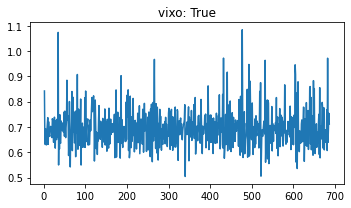

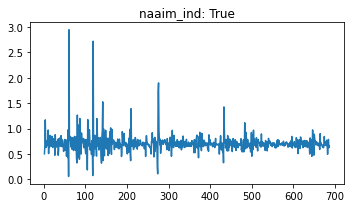

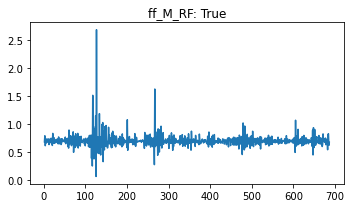

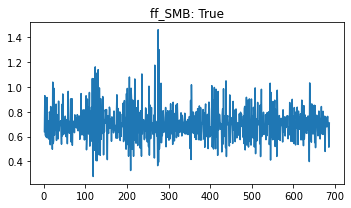

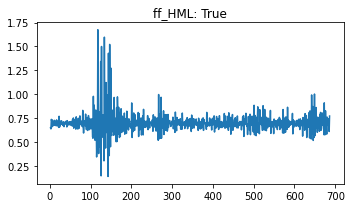

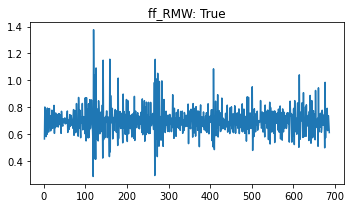

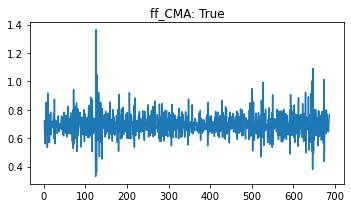

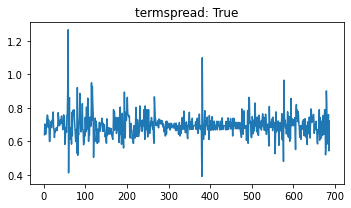

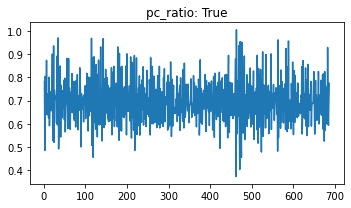

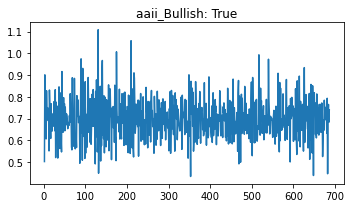

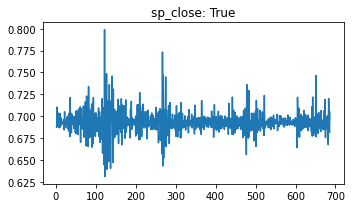

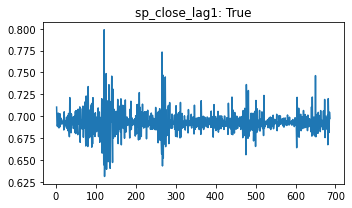

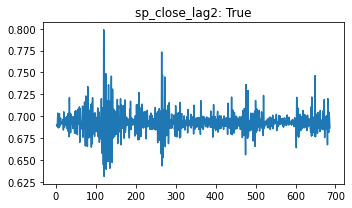

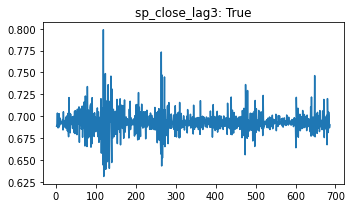

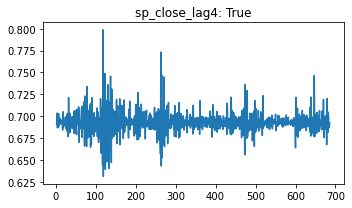

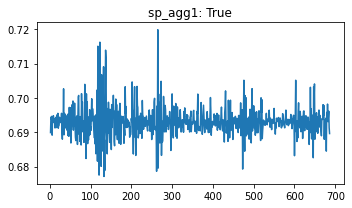

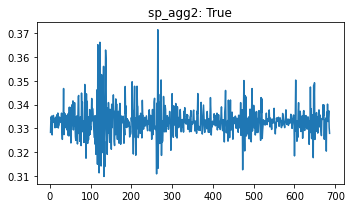

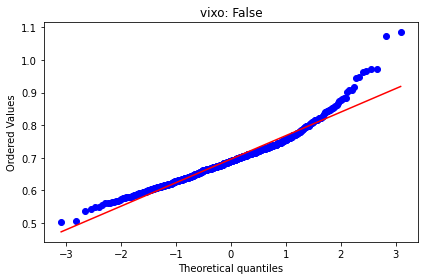

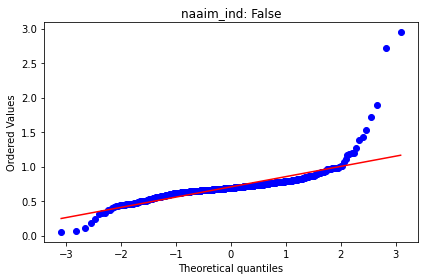

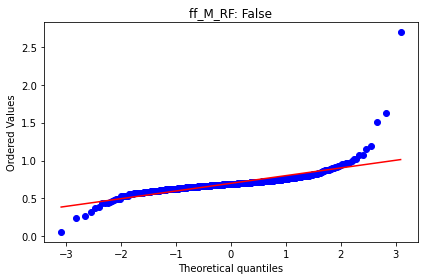

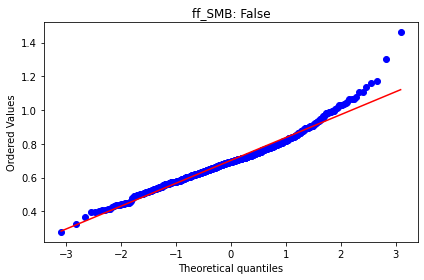

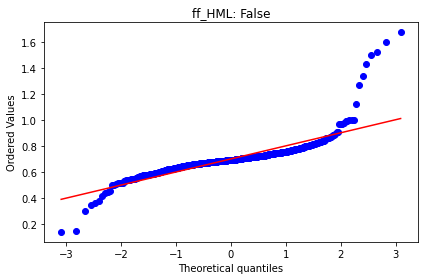

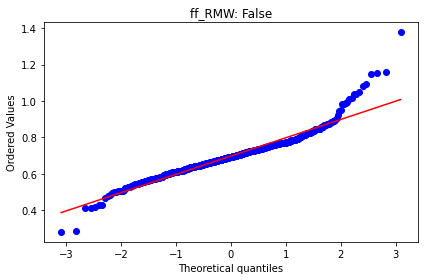

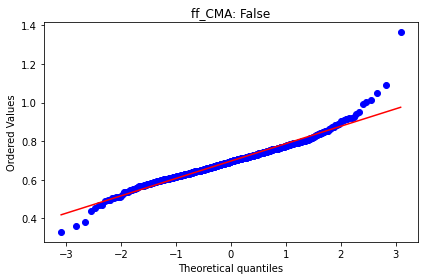

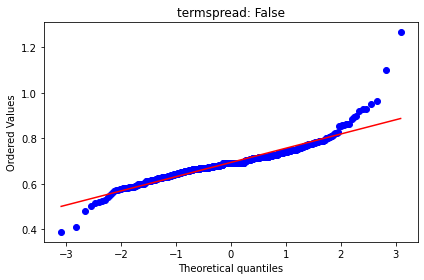

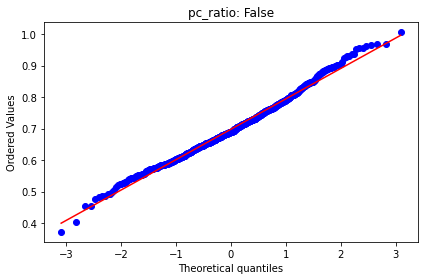

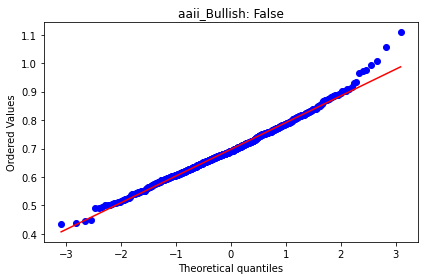

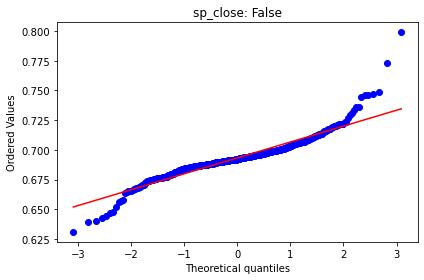

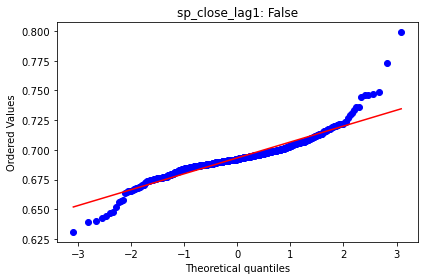

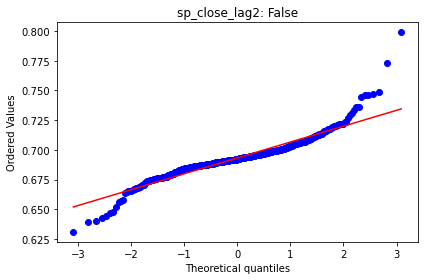

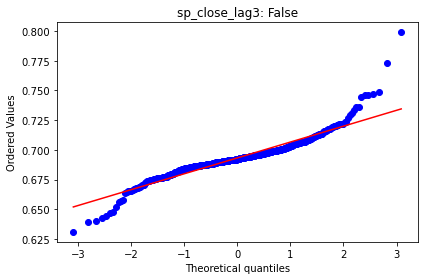

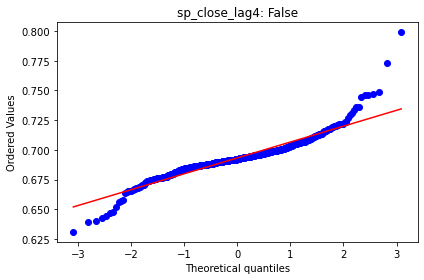

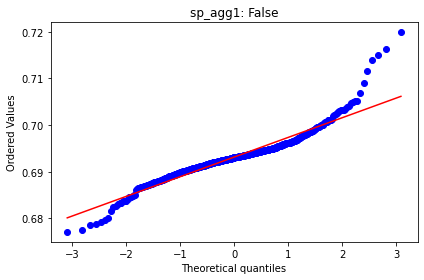

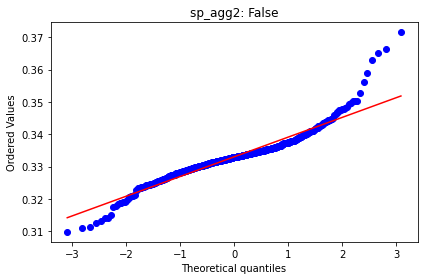

{'vixo': True,
 'naaim_ind': True,
 'ff_M_RF': True,
 'ff_SMB': True,
 'ff_HML': True,
 'ff_RMW': True,
 'ff_CMA': True,
 'termspread': True,
 'pc_ratio': True,
 'aaii_Bullish': True,
 'sp_close': True,
 'sp_close_lag1': True,
 'sp_close_lag2': True,
 'sp_close_lag3': True,
 'sp_close_lag4': True,
 'sp_agg1': True,
 'sp_agg2': True}

In [11]:
# test normality & stationarity
stest = StatsTest(plot=True)

stationarity = stest.df_test_stationarity(df_w, data_dict["relevant_cols"])
data_dict.update(stationarity=stationarity)

normality = stest.df_test_normality(df_w, cols=data_dict["relevant_cols"])
data_dict.update(normality=normality)

stationarity

# correlation

In [12]:
# select model features
# predicted lead1
# why ar3 model
cols = [
    'vixo',
     'naaim_ind',
     'ff_M_RF',
     # 'ff_SMB',
     'ff_RMW',
     # 'ff_CMA',
     # 'termspread',
     # 'pc_ratio',
     'aaii_Bullish',
    # 'ff_HML',
    'sp_close_lag2',
    'sp_agg1',
    # 'sp_agg2',
    # 'goog_sent',
    'sp_close_lag3',
    # 'fears35'
]

In [13]:
df_ws = df_w[cols + [data_dict["predicted"]]].copy()

In [14]:
data_dict["lag_correl"] = lag_correl(df_w,
                                     cols,
                                     col_predicted="sp_close_lag1",
                                     show_fig=False
                                     )
# data_dict["lag_correl"]

# Multicolinerarity

,VIF,corr_sp_close_lag1
sp_close_lag2,5302.075273,-0.567662
sp_agg1,14498.221453,-0.549095
ff_M_RF,38.139766,-0.408673
aaii_Bullish,66.693009,-0.241681
naaim_ind,16.765752,-0.128149
sp_close_lag3,3506.274821,0.079472
ff_RMW,55.042139,0.183751
vixo,104.020236,0.455076


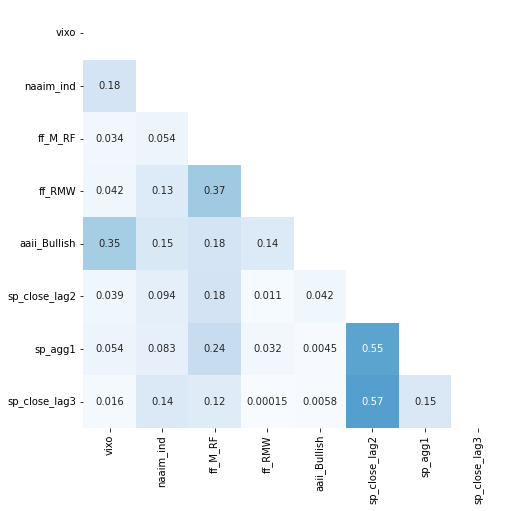

In [15]:
# only rely on correlation not vif
corr_heatmap(df_ws, 
             cols,
             size_factor=.9,
             show_fig=True)
get_variance_inflation_factor(df_ws, cols, col_pred=data_dict["predicted"])

# Orthogonalise

In [16]:
df_train = df_ws.copy()

In [17]:
# iteratives orthogonalisieren, eher nicht
df_train = orthogonalise_vars(df_train,
                              X="sp_close_lag2",
                              y="sp_agg1",
                              show_fig=False)

df_train = orthogonalise_vars(df_train,
                              X="sp_close_lag2",
                              y="sp_close_lag3",
                              show_fig=False)

df_train = orthogonalise_vars(df_train,
                              X="vixo",
                              y="sp_close_lag2",
                              show_fig=False)

df_train = orthogonalise_vars(df_train,
                              X="vixo",
                              y="aaii_Bullish",
                              show_fig=False)

df_train = orthogonalise_vars(df_train,
                              X="vixo",
                              y="ff_M_RF",
                              show_fig=False)

df_train = orthogonalise_vars(df_train,
                              X="vixo",
                              y="ff_RMW",
                              show_fig=False)

df_train = orthogonalise_vars(df_train,
                              X="vixo",
                              y="naaim_ind",
                              show_fig=False)

,VIF,corr_sp_close_lag1
sp_close_lag2,1.060541,-0.550272
ff_M_RF,1.280492,-0.393354
sp_close_lag3,1.085609,-0.294852
sp_agg1,1.106507,-0.285224
aaii_Bullish,1.052528,-0.086576
naaim_ind,1.054891,-0.048134
ff_RMW,1.187084,0.164927
vixo,1.000017,0.455076


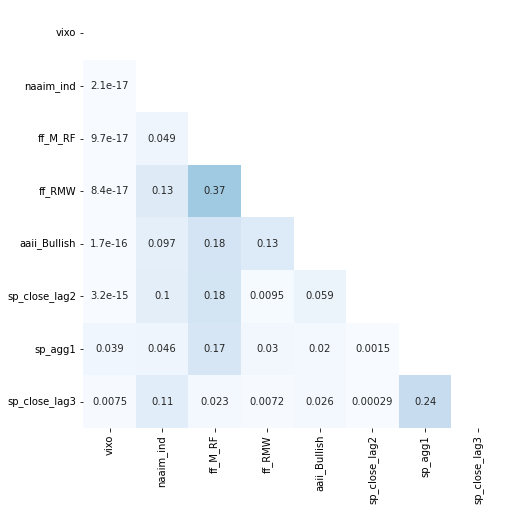

In [18]:
corr_heatmap(df_train, cols, size_factor=.9, show_fig=True)
get_variance_inflation_factor(df_train, cols, col_pred=data_dict["predicted"])

# Regression

In [19]:
X_train, X_test, y_train, y_test = tts_data(df_train, y=data_dict["predicted"], x=cols, random_split=False, test_size=.3)

In [20]:
model = sm.OLS(y_train, X_train, random_state=random_state).fit()

In [21]:
model.pvalues < 0.05

vixo             True
naaim_ind        True
ff_M_RF          True
ff_RMW           True
aaii_Bullish     True
sp_close_lag2    True
sp_agg1          True
sp_close_lag3    True
intercept        True
dtype: bool

In [22]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          sp_close_lag1   R-squared:                       0.728
Model:                            OLS   Adj. R-squared:                  0.723
Method:                 Least Squares   F-statistic:                     157.2
Date:                Wed, 09 Mar 2022   Prob (F-statistic):          1.17e-127
Time:                        09:27:46   Log-Likelihood:                 1627.0
No. Observations:                 479   AIC:                            -3236.
Df Residuals:                     470   BIC:                            -3198.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
vixo              0.0943      0.005     17.678      0.000       0.084       0.105
naaim_ind        -0.0044      0.002     -2.440      0.015      -0.008      -0.001
ff_M_RF          -0.0250      0.003     -8.419      0.000      -0.031      -0.019
ff_RMW            0.0098      0.004      2.572      0.010       0.002       0.017
aaii_Bullish     -0.0132      0.004     -3.086      0.002      -0.022      -0.005
sp_close_lag2    -0.5224      0.025    -20.990      0.000      -0.571      -0.474
sp_agg1          -0.5931      0.098     -6.036      0.000      -0.786      -0.400
sp_close_lag3    -0.3107      0.031    -10.151      0.000      -0.371      -0.251
intercept         0.6277      0.004    168.177      0.000       0.620       0.635
==============================================================================
Omnibus:                       92.216   Durbin-Watson:                   1.711
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              648.780
Skew:                           0.615   Prob(JB):                    1.32e-141
Kurtosis:                       8.567   Cond. No.                         322.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Out of sample eval

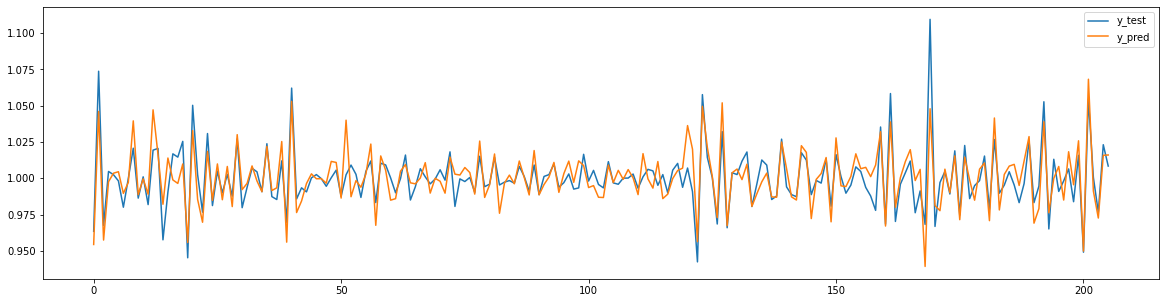

Validation Scores
mean squared error: 0.00013977
mean absolute error: 0.00882567
R2: 0.664


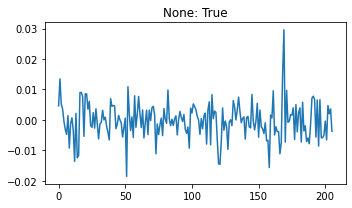

Stationarity Test Results
P-Values: 1.286284449207447e-24
Test-stats: -13.164663390746783
Time series is stationary: True


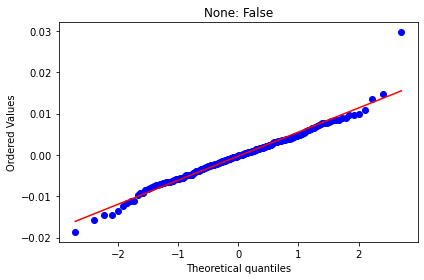

Normality Test Results
P-Values: 6.638932248689845e-06
Test-stats: 23.84511882665359
Series is normally distributed: False


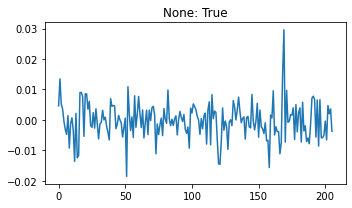

Test for Heteroskedasticity
Test p-value: 3.857895414487816e-07
Heteroskedasticity is present: True


In [23]:
# ar1 model als baseline
# add variables progressively, to obtain best
# random walk with drift, as benchmark model
# take root mean squared error as metrics
mval = ModelValidation(X_test,
                y_test,
                model,
                data_dict)
mval.get_model_performance()
mval.analyse_resids(print_results=True)

# Plot results

In [24]:
df_r = df_w.loc[df_ws.index].reset_index(drop=True).copy()

In [25]:
df_r["sp_tot_pred_test"] = np.concatenate([np.array(list([np.nan] * len(model.predict()))),
                                            mval.pred_inv.values]) * df_r["sp_true_vals"]

df_r["sp_tot_pred_train"] = np.concatenate([arr_inv_log_returns(model.predict()),
                                            np.array(list([np.nan] * len(mval.pred_inv.values)))]) * df_r["sp_true_vals"]

df_r["sp_tot_pred_train"] = df_r["sp_tot_pred_train"].shift(1)
df_r["sp_tot_pred_test"] = df_r["sp_tot_pred_test"].shift(1)

Validation Scores Test Data
mean squared error: 1863.7414558231474
mean absolute error: 32.00708938258228
mean absolute error %: 1.839223130130226


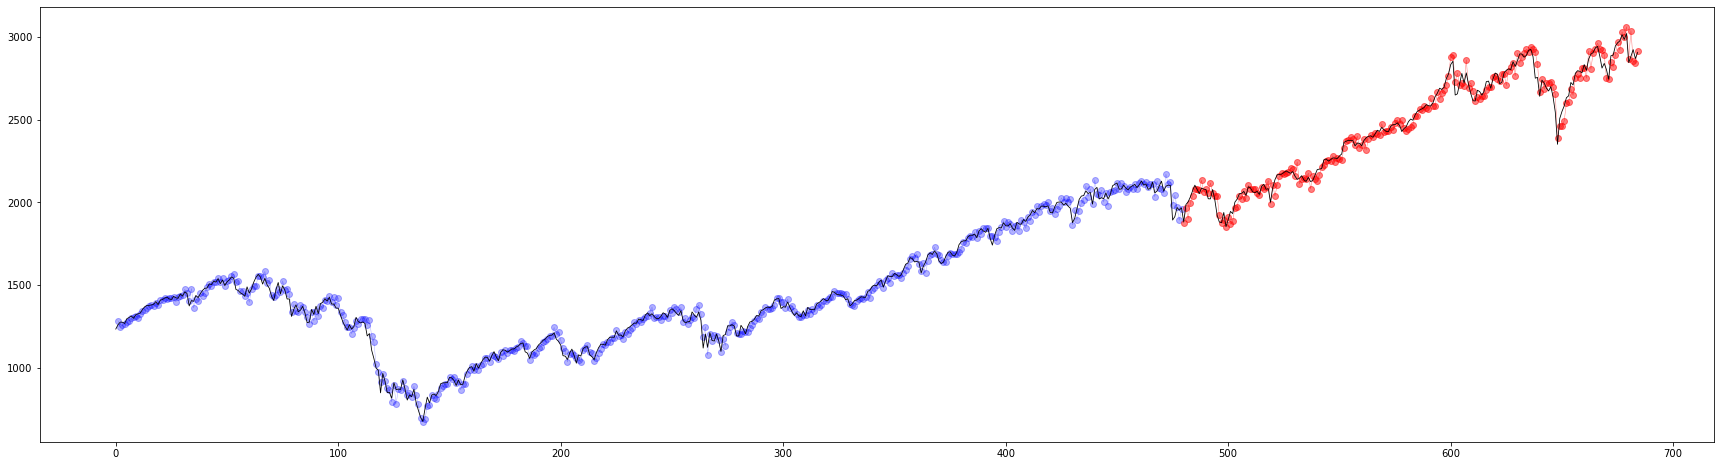

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(30, 8))
ax.plot(df_r["sp_tot_pred_train"], marker="o", lw=.5, alpha=.3, color="blue")
ax.plot(df_r["sp_tot_pred_test"], marker="o", lw=.5, alpha=.5, color="red")
ax.plot(df_r["sp_true_vals"], color="black", lw=.8)

# plt.xlim([500, 700])

print("Validation Scores Test Data")
print(f"mean squared error: {np.mean((df_r.sp_tot_pred_test - df_r[data_dict['sp_true_vals']]) ** 2)}")
print(f"mean absolute error: {np.mean(abs(df_r.sp_tot_pred_test - df_r[data_dict['sp_true_vals']]))}")
print(f"mean absolute error %: {(np.mean(abs(df_r.sp_tot_pred_test - df_r[data_dict['sp_true_vals']])) / df_r[data_dict['sp_true_vals']].mean()) * 100}")

# Save model

In [28]:
save_model(df_train, model, mval, data_dict, name="four_features_vixo_splag_splagmul_pcr_ffMRF", file_path=OUT_MODEL_DIR)

Are you sure you want to save model as: f"2022-03-08_four_features_vixo_splag_splagmul_pcr_ffMRF_model.pkl"? (y/n)


 y
